# Motion analyzer

August 11, 2018

In [60]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sg
import serial
import time

matplotlib.rcParams['figure.figsize'] = [10, 3]

SAMPLE_NUMS = 260  # sec
SAMPLING_RATE = 80.0  # Hz
GYRO_RESOLUTION = 250.0 / 32768.0
ACCEL_RESOLUTION = 2.0 / 32768.0
RAW_DATA_FILE = './raw_data.csv'
PORT = 'COM14'
TIME_INTERVAL = 260.0 / SAMPLING_RATE  # sec

RIM_SIZE = 20.0 * 2.54 / 100.0  # meter
RIM_DIAMTER = RIM_SIZE * np.pi 

def pulses2speed(pulses):
    running_distance_km = pulses * RIM_DIAMTER / 1000.0
    speed_km_per_hour = running_distance_km / TIME_INTERVAL * 3600.0
    return int(speed_km_per_hour)

## Dump raw data from the board to the file

In [61]:
ser = serial.Serial(PORT, 115200)
ser.write(b'd')
with open(RAW_DATA_FILE, 'w') as f:
    while True:
        line = ser.readline().decode('ascii')
        if line == '\n':
            break
        f.write(line)
ser.close()

## Plotting graph

In [62]:
df = pd.read_csv(RAW_DATA_FILE, dtype=np.int16)

gres = lambda v: v * GYRO_RESOLUTION
ares = lambda v: v * ACCEL_RESOLUTION
to_time = lambda v: v / SAMPLING_RATE
df[['gx', 'gy', 'gz']] = df[['gx', 'gy', 'gz']].apply(gres)
df[['ax', 'ay', 'az']] = df[['ax', 'ay', 'az']].apply(ares)
df[['cnt']] = df[['cnt']].apply(to_time)
df.set_index('cnt', drop=True, inplace=True)
measurements = df.tail(1).iloc[0,0] + 1
df.tail()

,id,gx,gy,gz,ax,ay,az,pls
cnt,,,,,,,,
29.1875,2,3.509521,15.365601,0.869751,0.302490,-0.082520,0.949951,0
29.2000,2,2.471924,2.212524,7.110596,0.288330,-0.072937,0.965820,0
29.2125,2,0.595093,-2.029419,-5.477905,0.292542,-0.078491,0.946350,0
29.2250,2,-5.172729,2.563477,-4.409790,0.291565,-0.080994,0.940674,0
29.2375,2,-2.075195,-14.801025,2.624512,0.298340,-0.078125,0.959106,0


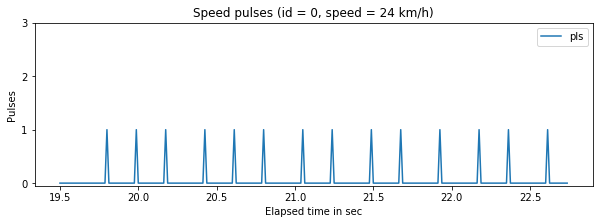

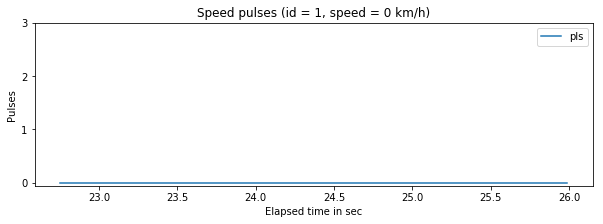

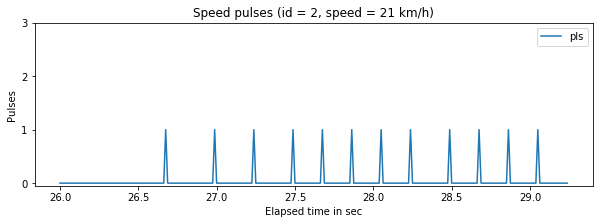

In [63]:
for i in range(measurements):
    df2 = df[df['id']==i]
    ax = df2[['pls']].plot(yticks=[0,1,2,3])
    pulses = df2['pls'].sum()
    ax.set_xlabel('Elapsed time in sec')
    ax.set_ylabel('Pulses')
    ax.set_title('Speed pulses (id = {}, speed = {} km/h)'.format(i, pulses2speed(pulses)))

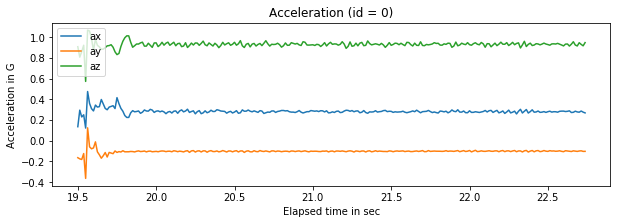

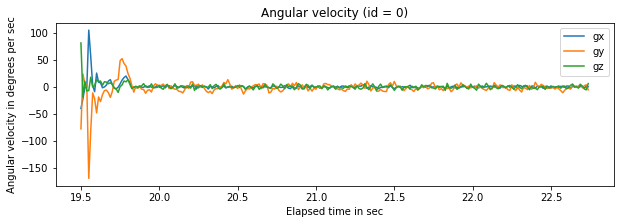

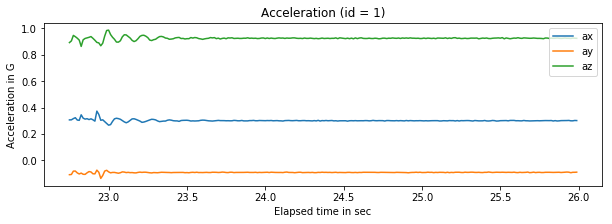

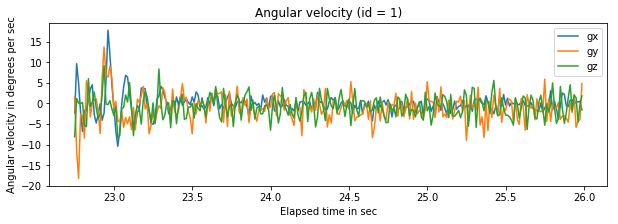

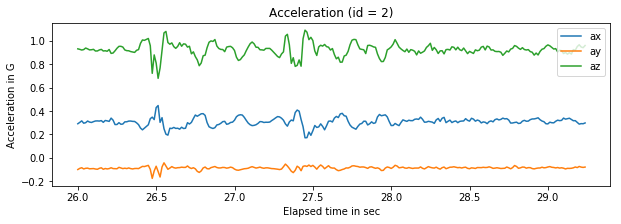

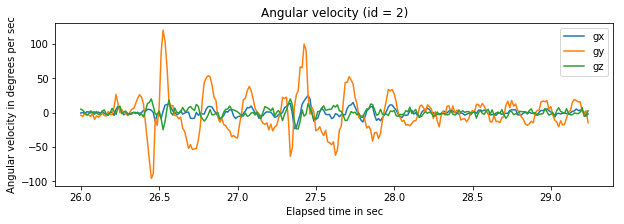

In [64]:
for i in range(measurements):
    df2 = df[df['id']==i]
    ax = df2[['ax', 'ay', 'az']].plot()
    ax.set_xlabel('Elapsed time in sec')
    ax.set_ylabel('Acceleration in G')
    ax.set_title('Acceleration (id = {})'.format(i))
    ax = df2[['gx', 'gy', 'gz']].plot()
    ax.set_xlabel('Elapsed time in sec')
    ax.set_ylabel('Angular velocity in degrees per sec')
    ax.set_title('Angular velocity (id = {})'.format(i))

In [65]:
CUTOFF = 5.0
b, a = sg.butter(5, CUTOFF/SAMPLING_RATE, btype='low')
df[['ax', 'ay', 'az']] = df[['ax', 'ay', 'az']].apply(lambda row: sg.lfilter(b, a, row))

In [66]:
CUTOFF = 3.0
b, a = sg.butter(5, CUTOFF/SAMPLING_RATE, btype='low')
df[['gx', 'gy', 'gz']] = df[['gx', 'gy', 'gz']].apply(lambda row: sg.lfilter(b, a, row))

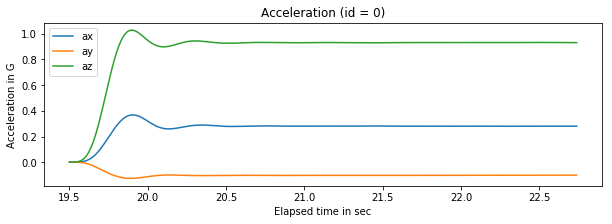

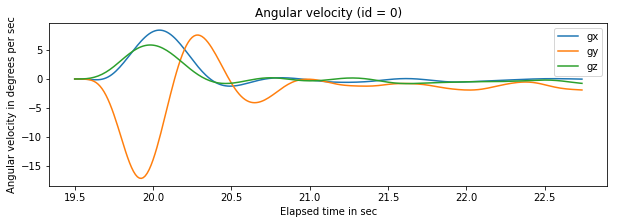

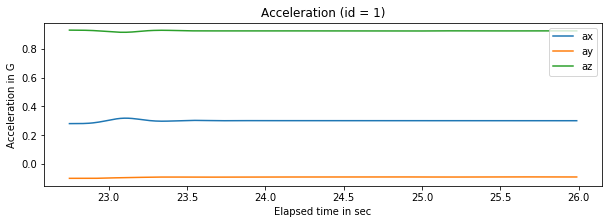

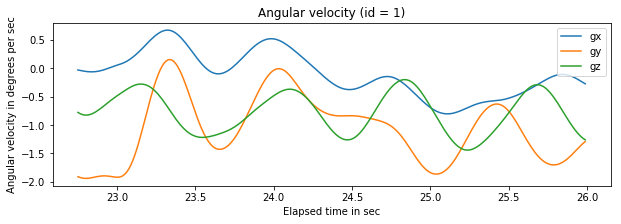

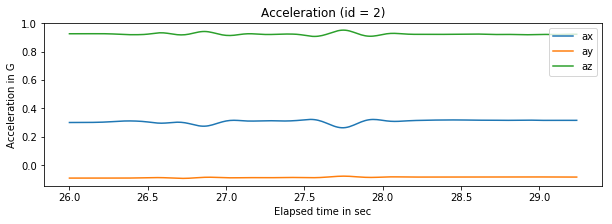

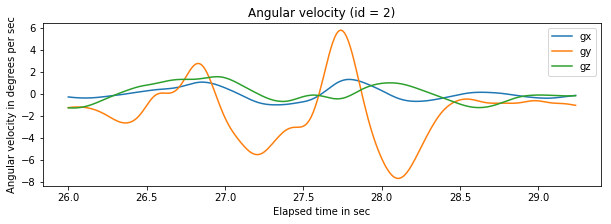

In [67]:
for i in range(measurements):
    df2 = df[df['id']==i]
    ax = df2[['ax', 'ay', 'az']].plot()
    ax.set_xlabel('Elapsed time in sec')
    ax.set_ylabel('Acceleration in G')
    ax.set_title('Acceleration (id = {})'.format(i))
    ax = df2[['gx', 'gy', 'gz']].plot()
    ax.set_xlabel('Elapsed time in sec')
    ax.set_ylabel('Angular velocity in degrees per sec')
    ax.set_title('Angular velocity (id = {})'.format(i))